# Visualization/Analysis of Local GTFS-RT

In [1]:
import json
import os

from datetime import datetime, timezone
from dateutil import tz


import branca.colormap as cm
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import seaborn as sns

TZ = pytz.timezone('America/Los_Angeles')
sns.set_style('whitegrid')

In [2]:
corridor_segments = {
    0: {
        2749,
        2751,
        2752,
        2753,
        2754,
        2755,
        2756,
        2757
    },
    1: {
        12200,
        12201,
        12202,
        12203,
        12204
    },
    2: {
        13532,
        13533,
        13534,
        13535,
        13536
    },
    3: {
        14585,
        14586,
        14587,
        14589,
        14590,
        14591,
        14243
    },
    4: {
        8510,
        8511,
        8512,
        8513,
        8514
    },
    5: {
        13221,
        13220,
        13219,
        13218,
        13217
    },
    6: {
        18045,
        18046,
        18047,
        18048,
        18049
    },
    7: {
        19235,
        19234,
        11333,
        11331,
        11330,
        11329,
        19212
    },
    8: {
        12369,
        12366,
        12365,
        12364,
        12363
    }
}
corridor_names = ['2nd Ave; Pike to James',
                 'Pike; 3rd to 9th',
                 'Westlake; Denny to Mercer',
                 'E Olive/E John; Denny to 10th',
                 '9th Ave; Alder to Columbia',
                 'University Way; Campus Pkwy to 45th',
                  'Pacific; 15th to Montlake',
                  'NW Market/Leary; 24th to 15th',
                  'Rainier; S Bayview to MLK',
                  '108th Ave; 4th to 12th']

### Process the Local Summarize_RDS Data

In [3]:
# Location for the local data
path = './transit_vis/data/to_upload'

# Join all the data which is saved in different csv for each day
# files = os.listdir(path)
# frames = [pd.read_csv(f"{path}/{filename}", dtype={'trip_short_name': str, 'route_short_name': str}) for filename in files[0:30]]
# all_data = pd.concat(frames)
# all_data.to_csv(f"{path}/../all_data.csv")
# all_data.head()

# If already processed, load the data here and comment out above
all_data = pd.read_csv(f"{path}/../all_data.csv", dtype={'trip_short_name': str, 'route_short_name': str})

# Add date to the data
all_data['day'] = pd.to_datetime(all_data['locationtime'], unit='s')
all_data['day'] = all_data['day'].dt.strftime('%Y-%m-%d')

# Add corridor id to the data
def get_dict_key(value, corridor_dict):
    for corridor in corridor_dict:
        if value in corridor_dict[corridor]:
            return corridor
    return -1
all_data['corridor_id'] = all_data['seg_compkey'].apply(get_dict_key, args=(corridor_segments,))

# REMOVE ALL DATA NOT IN CORRIDORS
# all_data = all_data[all_data['corridor_id']>=0]

# Add travel time to the data
# Use difference in the first/last time each unique trip is recorded on a corridor's segments for each day
tt_data = all_data[all_data['corridor_id']>=0]
tt_data = tt_data.groupby(['corridor_id','day','tripid']).agg(['max','min'])[['locationtime']]
tt_data.reset_index(inplace=True)
tt_data['tt'] = tt_data[('locationtime','max')] - tt_data[('locationtime','min')]
tt_data.columns = tt_data.columns.droplevel(1)

# Some interferences are matched to GTFS data that was assigned to segments outside of the corridor; these are left empty
# This only affects traversal times. The tt cannot be calculated for tracked locations outside of a corridor
all_data = pd.merge(all_data, tt_data[['corridor_id','day','tripid','tt']], on=['corridor_id','day','tripid'], how='left')

all_data.head()

,Unnamed: 0,tripid,vehicleid,lat,lon,orientation,scheduledeviation,prev_deviation,totaltripdistance,tripdistance,...,trip_short_name,route_short_name,seg_compkey,seg_length,seg_route_id,seg_lat,seg_lon,day,corridor_id,tt
0,0,34746102.0,8188,47.580441,-122.152702,180,80,48.0,21489.267668,10.359279,...,LOCAL,271,493119,2341,100162,47.6409,-122.25898,2021-03-12,-1,NaN
1,1,34746102.0,8188,47.579819,-122.147911,358,42,80.0,21489.267668,517.963526,...,LOCAL,271,493119,2341,100162,47.6409,-122.25898,2021-03-12,-1,NaN
2,2,34746102.0,8188,47.579685,-122.144455,358,6,42.0,21489.267668,771.837350,...,LOCAL,271,493119,2341,100162,47.6409,-122.25898,2021-03-12,-1,NaN
3,3,34746102.0,8188,47.581799,-122.142326,133,-1,6.0,21489.267668,1207.902715,...,LOCAL,271,493119,2341,100162,47.6409,-122.25898,2021-03-12,-1,NaN
4,4,34746102.0,8188,47.585056,-122.142754,90,-42,-1.0,21489.267668,1572.377132,...,LOCAL,271,493119,2341,100162,47.6409,-122.25898,2021-03-12,-1,NaN


### Create Distributions of Metrics for Buses with/without Interference

In [4]:
interference_data = pd.read_csv(f"{path}/../interference_instances_new.csv")
interference_data['start_time'] = pd.to_datetime(interference_data['int_start_time']).dt.tz_localize(tz.tzlocal()).astype(int).astype(str).str.slice(0,10).astype(int)
interference_data['stop_time'] = pd.to_datetime(interference_data['int_stop_time']).dt.tz_localize(tz.tzlocal()).astype(int).astype(str).str.slice(0,10).astype(int)
interference_data['corridor_id'] = interference_data['corridor_id'] - 1
interference_data.head()

,Unnamed: 0,corridor_id,corridor_name,vehicle_id,int_location_tyoe,lat,lon,mode,int_start_time,int_stop_time,first_name,difference,report_date,start_time,stop_time
0,1,1,Pike;\r\n3rd to 9th,7151,In a driving lane,47.610556,-122.335928,Construction,2021-03-05 07:19:24,2021-03-05 07:19:26,Travis,2,2021-03-05,1614957564,1614957566
1,2,1,Pike;\r\n3rd to 9th,9647,In a driving lane,47.610657,-122.335785,Construction,2021-03-05 07:36:34,2021-03-05 07:36:36,Travis,2,2021-03-05,1614958594,1614958596
2,3,1,Pike;\r\n3rd to 9th,4508,In a driving lane,47.610609,-122.336568,Construction,2021-03-05 07:38:58,2021-03-05 07:39:00,Travis,2,2021-03-05,1614958738,1614958740
3,4,5,University Way;\r\nCampus to 45th,6895,In a driving lane,47.658530,-122.313270,Service Vehicle,2021-03-08 07:48:09,2021-03-08 07:48:11,Andrew,2,2021-03-08,1615218489,1615218491
4,5,5,University Way;\r\nCampus to 45th,8048,In a driving lane,47.658636,-122.313270,Pedestrian,2021-03-08 08:04:34,2021-03-08 08:04:38,Andrew,4,2021-03-08,1615219474,1615219478


In [5]:
# Track down the datapoints in GTFS-RT that correspond to each interference instance
idx_interference = []  # The index of the interference in the interference data
data_interference = []  # Data for +/- xmins from the interference in GTFS-RT
datarow_interference = []  # What row of the +/- xmins GTFS-RT data the interference corresponds to

for idx, row in interference_data.iterrows():

    # Get the tracked datapoints corresponding to +/- xmins of the data; FROM THE START of the interference
    found = False
    margin_mins = 2
    margin = margin_mins*60  # xmins in seconds
    data = all_data[all_data['vehicleid'] == row.vehicle_id]
    data = data[(data['locationtime']>=(row.start_time - margin)) & (data['locationtime']<=(row.start_time + margin))]
    
    # Get the metric across the time period where the interference occurred
    if len(data) > 0:
        data = data.sort_values(by='locationtime', ascending=True)
        for j, time in enumerate(data['locationtime']):
            if row.start_time <= time:
                idx_interference.append(idx)
                datarow_interference.append(j-1)
                # Get time variable for each interference that is +/- seconds from 0; where 0 is the time of the interference
                data['time_from_interference'] = data['locationtime'] - data['locationtime'].iloc[j-1]
                # Get schedule deviation variable for each location with interference at 0
                data['deviation_from_interference'] = data['scheduledeviation'] - data['scheduledeviation'].iloc[j-1]
                data['interference_id'] = str(idx)
                data_interference.append(data)
                found = True
                break
        if not found:
            print(f"Interference {idx} vehicle id {row.vehicle_id} Fell outside data")
    else:
        print(f"Interference {idx} vehicle id {row.vehicle_id} No data found")
        continue

Interference 1 vehicle id 9647 No data found
Interference 19 vehicle id 8142 No data found
Interference 21 vehicle id 7196 No data found
Interference 22 vehicle id 9641 No data found
Interference 23 vehicle id 303 No data found
Interference 24 vehicle id 7425 No data found
Interference 25 vehicle id 41514 No data found
Interference 26 vehicle id 9672 No data found


/home/zack/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zack/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


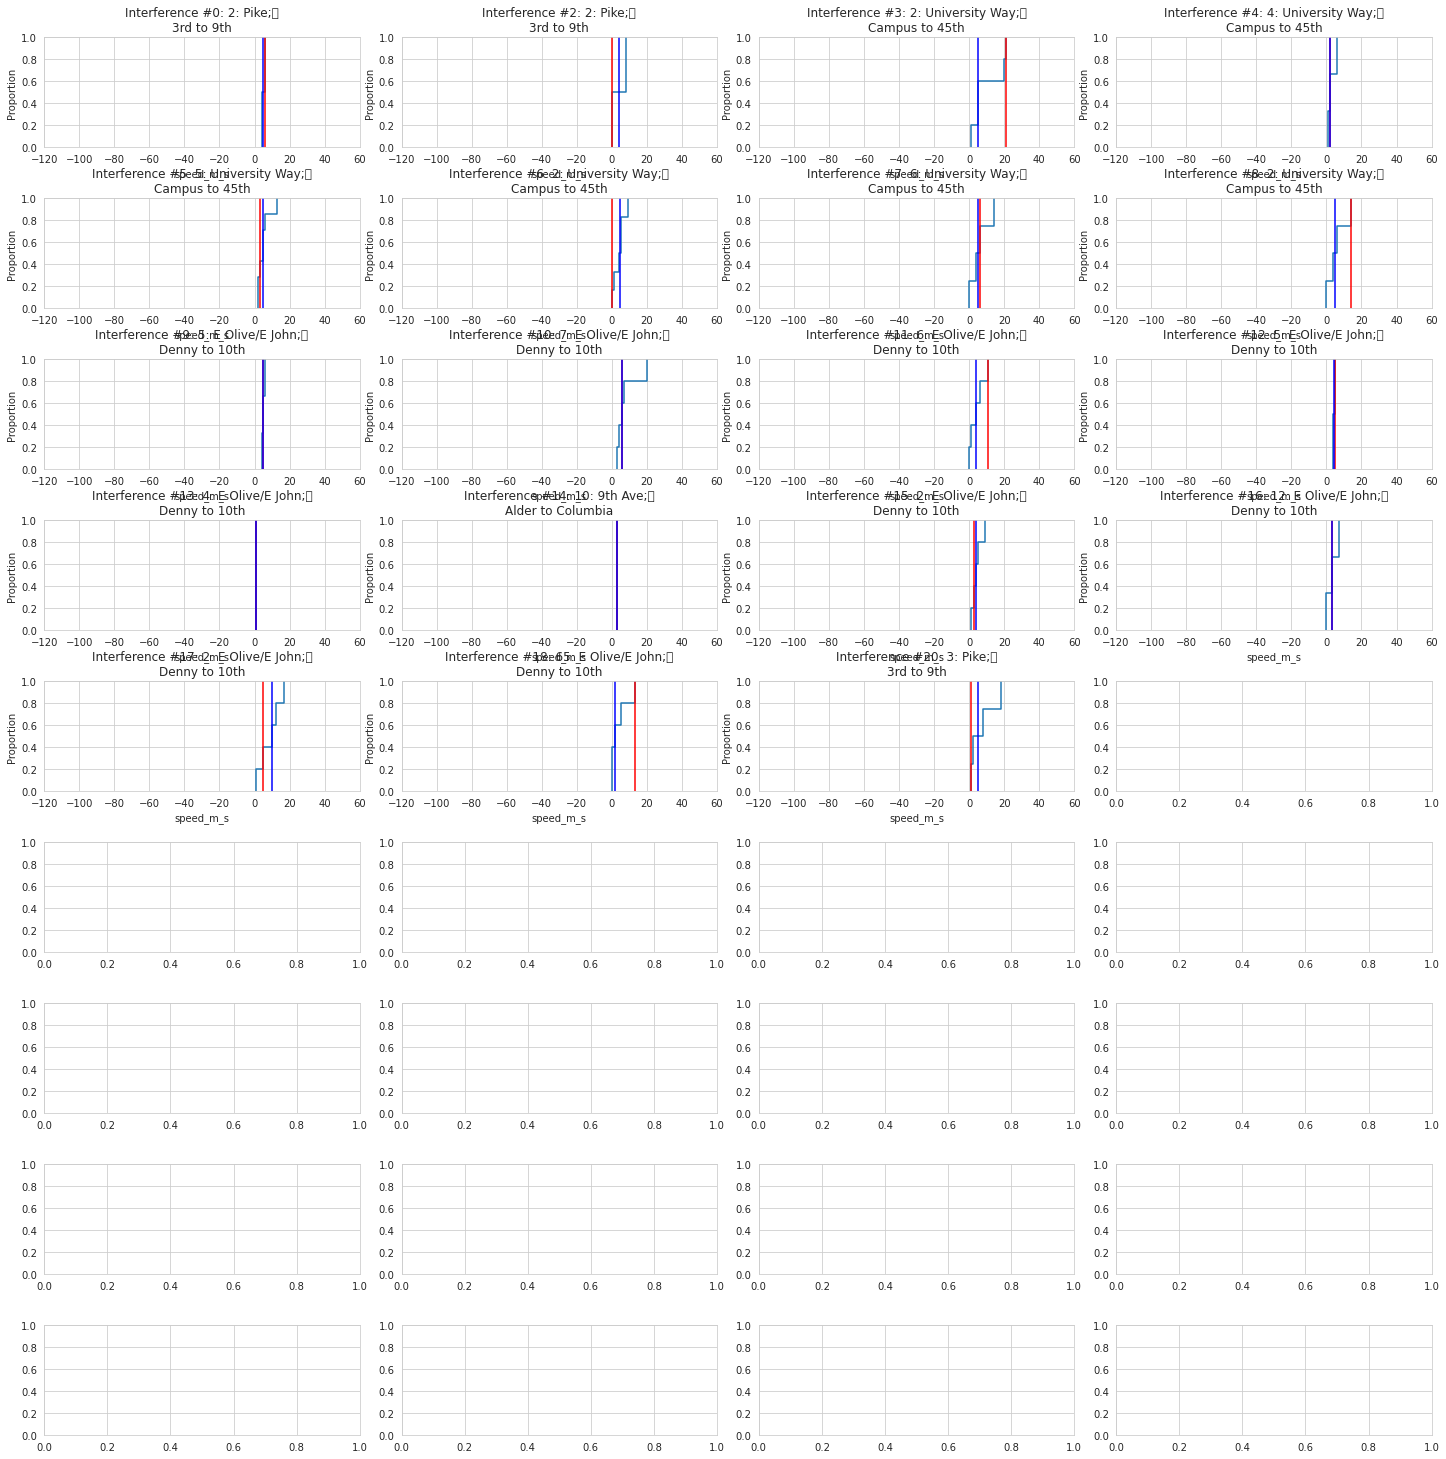

In [6]:
fig, axes = plt.subplots(9,4,figsize=(20,20))
fig.tight_layout(h_pad=3)

for i, idx in enumerate(idx_interference):
    sns.ecdfplot(data=data_interference[i], x='speed_m_s', ax=axes.flat[i]).set(xlim=(-120,60), title=f"Interference #{idx}: {interference_data['difference'][idx]}: {interference_data['corridor_name'][idx]}")
    axes.flat[i].axvline(data_interference[i]['speed_m_s'].iloc[datarow_interference[i]], color='red')
    axes.flat[i].axvline(np.median(data_interference[i]['speed_m_s']), color='blue')

fig.savefig(fname="interference_speeds")

/home/zack/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zack/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


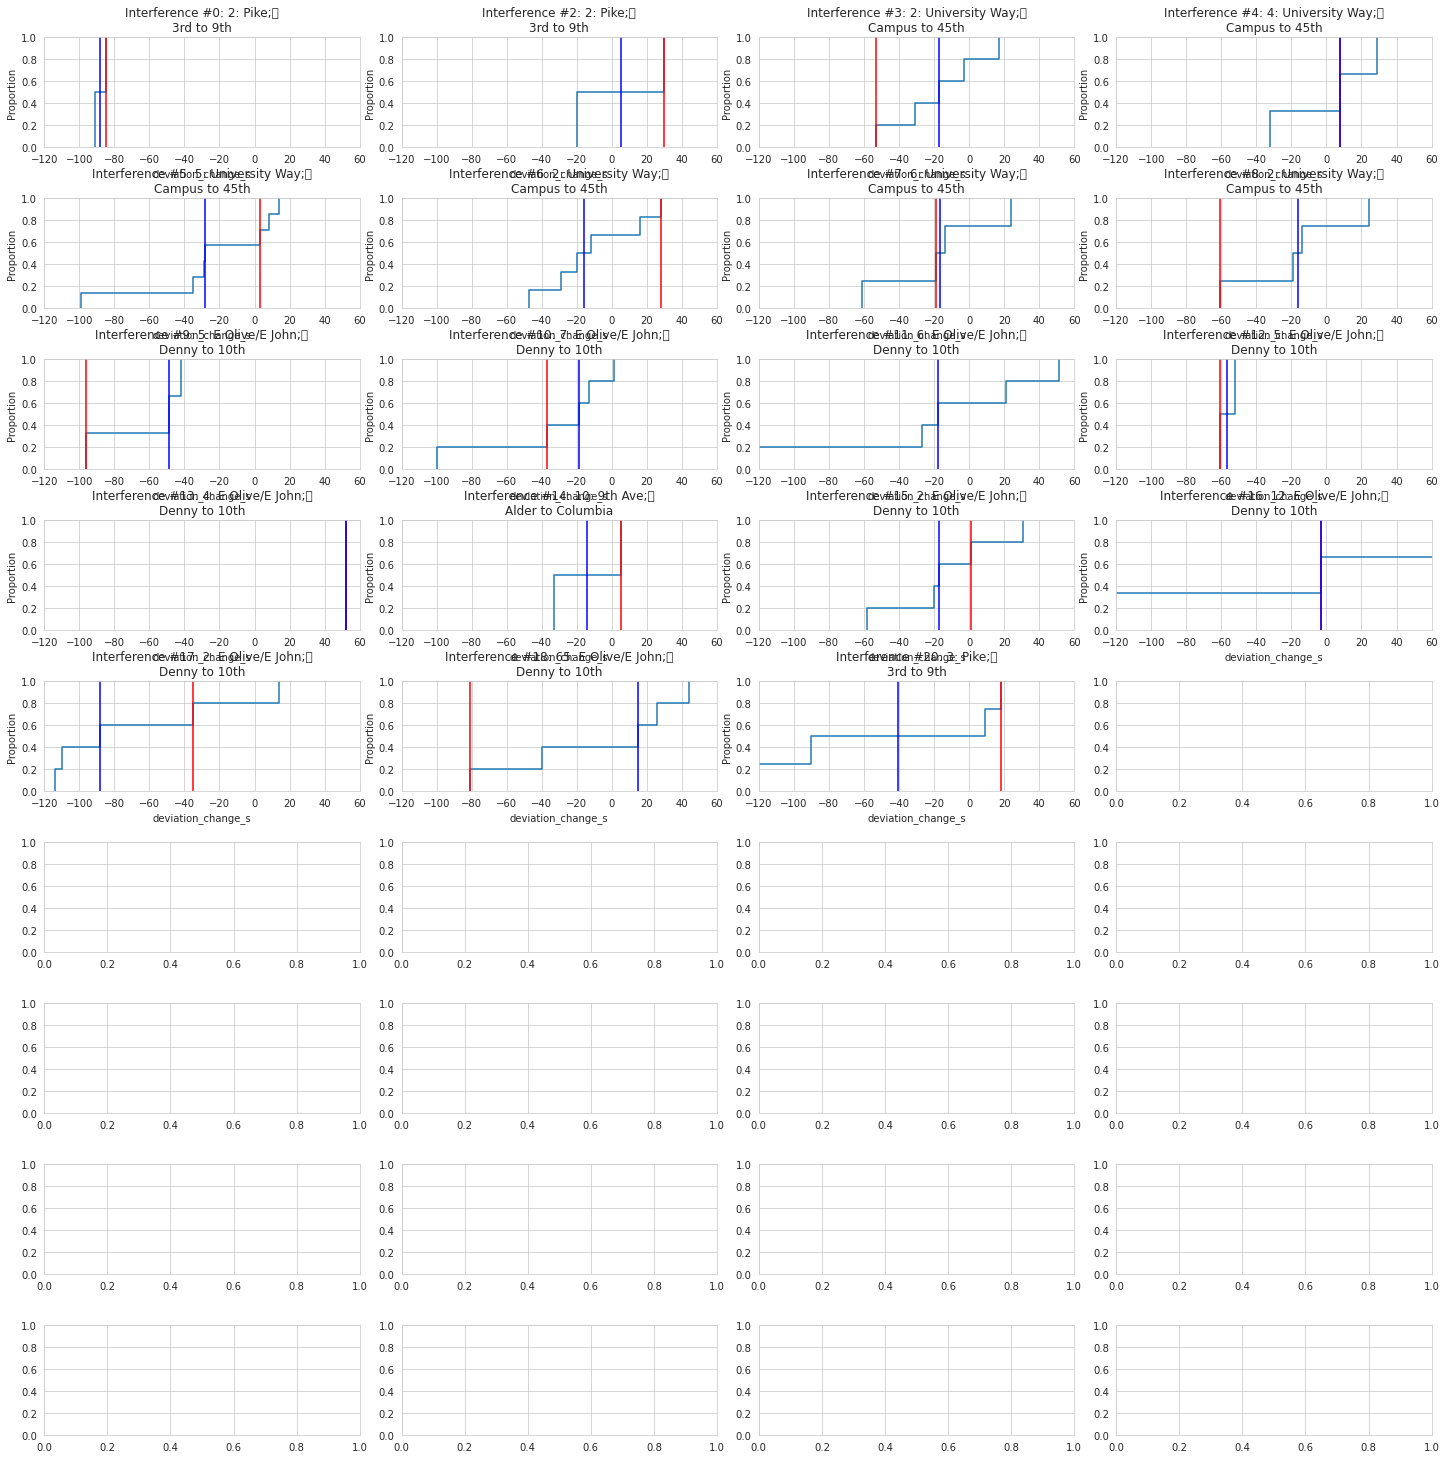

In [7]:
fig, axes = plt.subplots(9,4,figsize=(20,20))
fig.tight_layout(h_pad=3)

for i, idx in enumerate(idx_interference):
    sns.ecdfplot(data=data_interference[i], x='deviation_change_s', ax=axes.flat[i]).set(xlim=(-120,60), title=f"Interference #{idx}: {interference_data['difference'][idx]}: {interference_data['corridor_name'][idx]}")
    axes.flat[i].axvline(data_interference[i]['deviation_change_s'].iloc[datarow_interference[i]], color='red')
    axes.flat[i].axvline(np.median(data_interference[i]['deviation_change_s']), color='blue')

fig.savefig(fname="interference_deviation_changes")

In [8]:
all_data

,Unnamed: 0,tripid,vehicleid,lat,lon,orientation,scheduledeviation,prev_deviation,totaltripdistance,tripdistance,...,trip_short_name,route_short_name,seg_compkey,seg_length,seg_route_id,seg_lat,seg_lon,day,corridor_id,tt
0,0,34746102.0,8188,47.580441,-122.152702,180,80,48.0,21489.267668,10.359279,...,LOCAL,271,493119,2341,100162,47.64090,-122.25898,2021-03-12,-1,NaN
1,1,34746102.0,8188,47.579819,-122.147911,358,42,80.0,21489.267668,517.963526,...,LOCAL,271,493119,2341,100162,47.64090,-122.25898,2021-03-12,-1,NaN
2,2,34746102.0,8188,47.579685,-122.144455,358,6,42.0,21489.267668,771.837350,...,LOCAL,271,493119,2341,100162,47.64090,-122.25898,2021-03-12,-1,NaN
3,3,34746102.0,8188,47.581799,-122.142326,133,-1,6.0,21489.267668,1207.902715,...,LOCAL,271,493119,2341,100162,47.64090,-122.25898,2021-03-12,-1,NaN
4,4,34746102.0,8188,47.585056,-122.142754,90,-42,-1.0,21489.267668,1572.377132,...,LOCAL,271,493119,2341,100162,47.64090,-122.25898,2021-03-12,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313035,256206,49788350.0,8143,47.472652,-122.209435,202,-1098,-933.0,22121.419355,21596.167775,...,LOCAL,101,10240,225,100003,47.49553,-122.26840,2021-03-10,-1,NaN
2313036,256207,49788350.0,8143,47.472622,-122.209496,204,-1085,-1098.0,22121.419355,21603.668160,...,LOCAL,101,10240,225,100003,47.49553,-122.26840,2021-03-10,-1,NaN
2313037,256208,49788351.0,8143,47.609028,-122.336243,203,16,-6.0,22121.419355,69.320040,...,LOCAL,101,13182,98,100003,47.60922,-122.33578,2021-03-10,-1,NaN
2313038,256209,49788351.0,8143,47.609001,-122.336296,204,-2,16.0,22121.419355,159.938757,...,LOCAL,101,13182,98,100003,47.60922,-122.33578,2021-03-10,-1,NaN


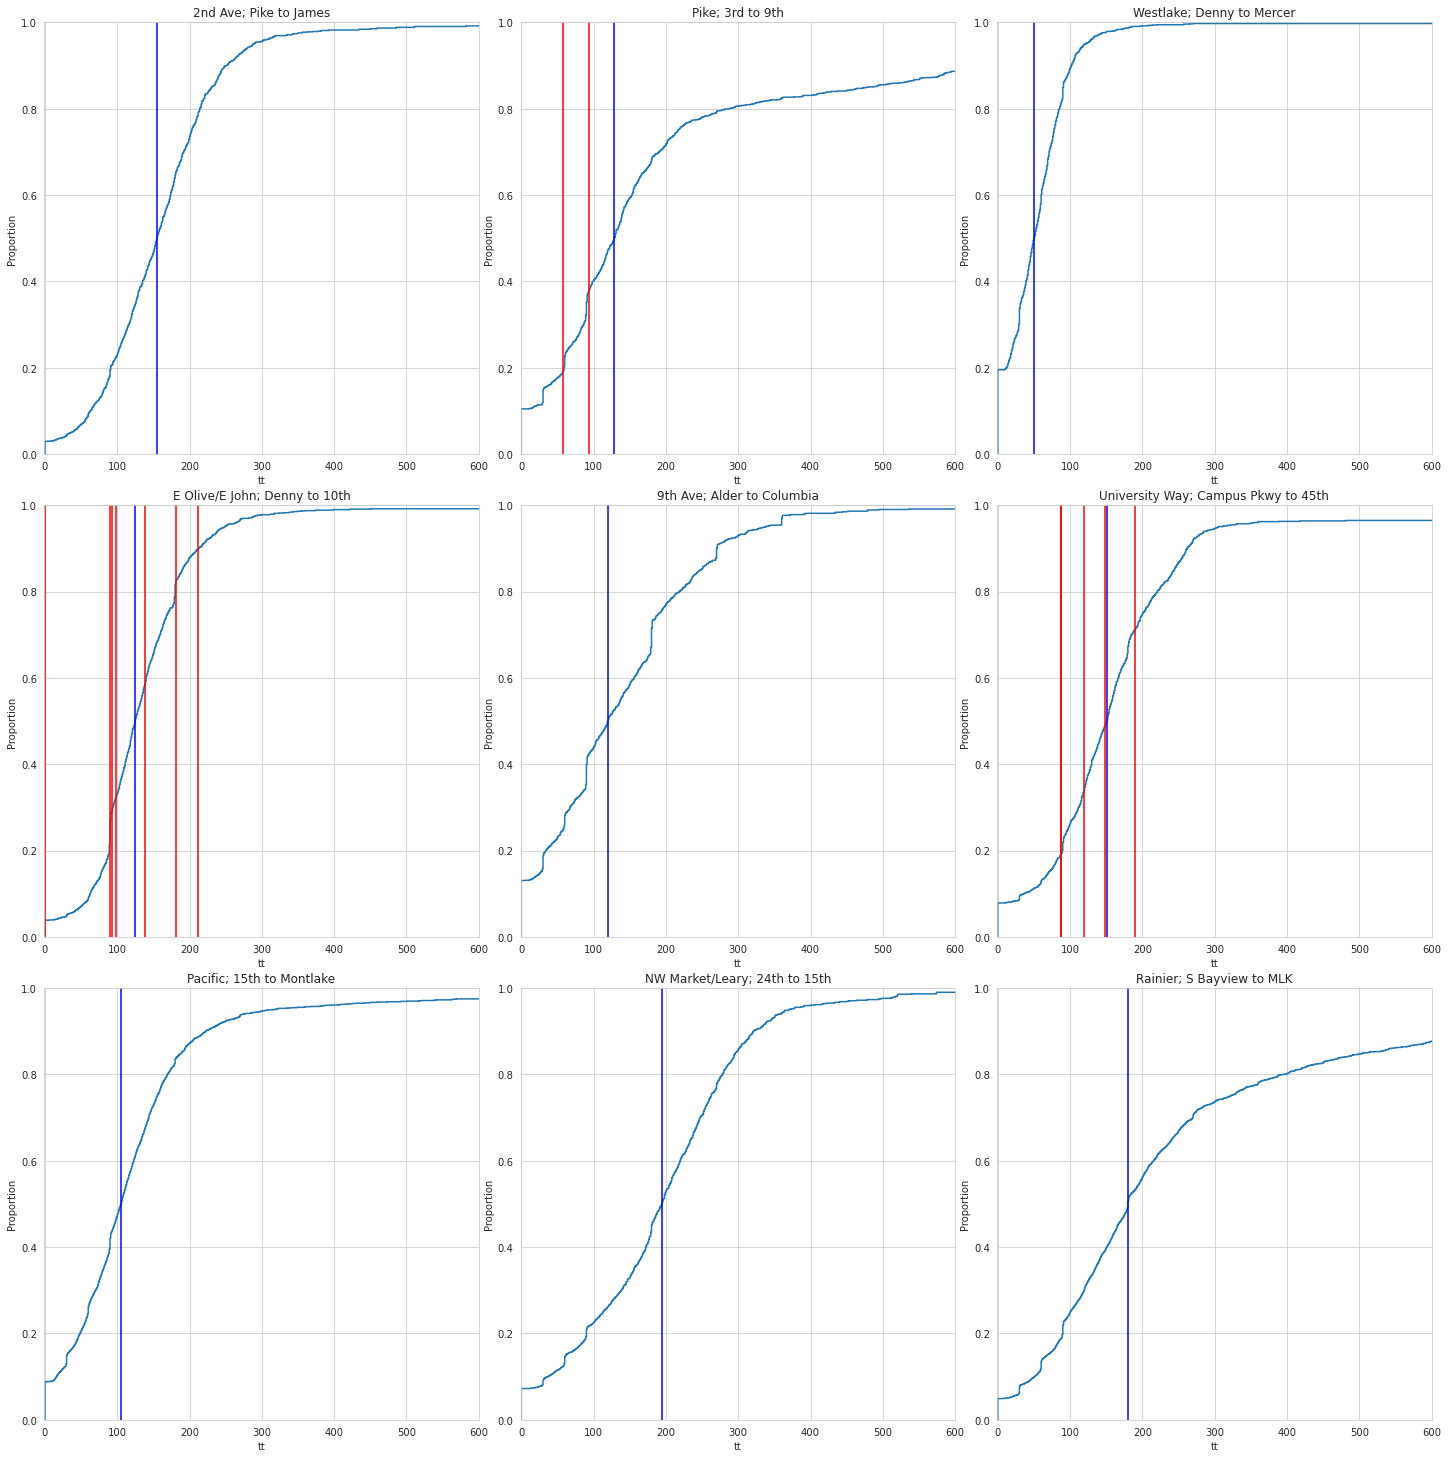

In [9]:
fig, axes = plt.subplots(3,3,figsize=(20,20))
fig.tight_layout(h_pad=3)

for i in range(9):  # No Bellevue corridor because using the Seattle Streets dataset to map match coords
    full_data = all_data[all_data['corridor_id']==i]
    sns.ecdfplot(data=full_data, x='tt', ax=axes.flat[i]).set(xlim=(-1,600), title=f"{corridor_names[i]}")
    for j in range(len(idx_interference)):
        if data_interference[j]['corridor_id'].iloc[datarow_interference[j]]==i:
            axes.flat[i].axvline(data_interference[j]['tt'].iloc[datarow_interference[j]], color='red')
    axes.flat[i].axvline(np.median(full_data['tt']), color='blue')
    
fig.savefig(fname="corridor_traversal_times")

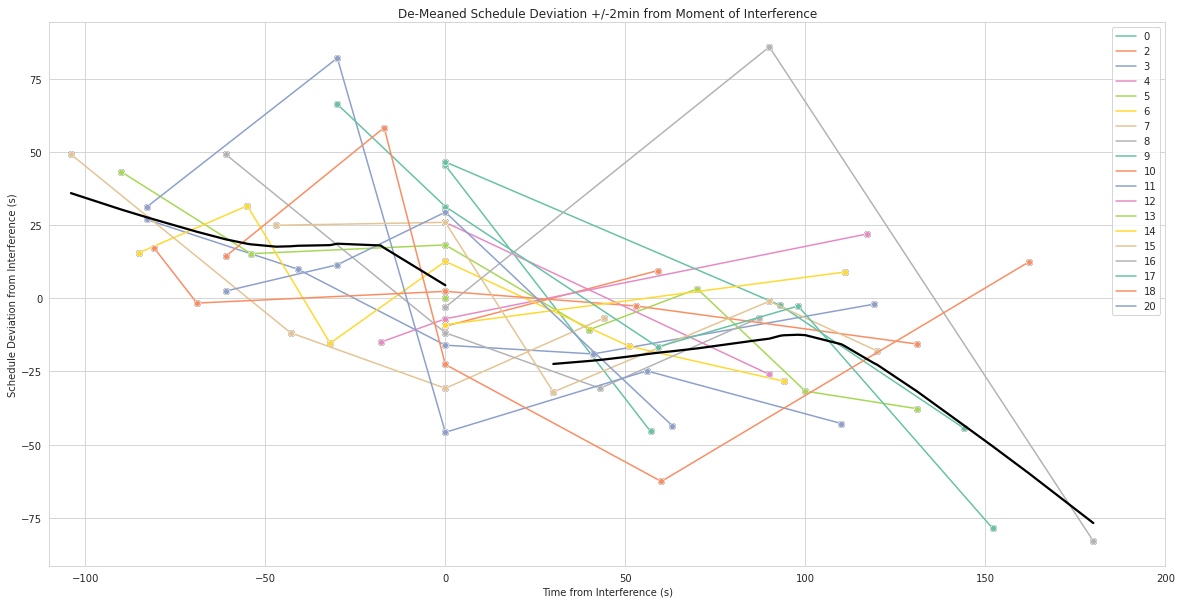

In [10]:
# Create column for de-meaned values in the timeseries data
for i in range(len(data_interference)):
    norm = np.mean(data_interference[i]['scheduledeviation'])
    data_interference[i]['scheduledeviation_norm'] = data_interference[i]['scheduledeviation'] - norm

fig, axes = plt.subplots(1,1,figsize=(20,10))

# Event study timeseries plot per interference
sns.lineplot(data=pd.concat(data_interference),
             x="time_from_interference",
             y="scheduledeviation_norm",
             hue="interference_id",
             palette='Set2',
             marker='o',
             ax=axes).set(xlim=(-120,120), xlabel='Time from Interference (s)', ylabel='Schedule Deviation (s)', title=f"De-Meaned Schedule Deviation +/-{margin_mins}min from Moment of Interference")

# LOWESS regression for data before interference
sns.regplot(data=pd.concat(data_interference)[pd.concat(data_interference)['time_from_interference']<=0],
             x="time_from_interference",
             y="scheduledeviation_norm",
             lowess=True,
             color='black').set(xlim=(-110,200), xlabel='Time from Interference (s)', ylabel='Schedule Deviation from Interference (s)')

# LOWESS regression for data after interference
sns.regplot(data=pd.concat(data_interference)[pd.concat(data_interference)['time_from_interference']>0],
             x="time_from_interference",
             y="scheduledeviation_norm",
             lowess=True,
             color='black').set(xlim=(-110,200), xlabel='Time from Interference (s)', ylabel='Schedule Deviation from Interference (s)')
plt.legend(loc='upper right')

fig.savefig(fname="event_study_plot")

### Find Top 10/Top Random Coaches that Spend Most Time in Corridors, and Avg Unique Corridor Traversals

In [11]:
# Filter to period of interest
# start_time = 1607072400 # 12/4/20 1AM
# end_time = 1608282000 # 12/18/20 1AM
start_time = 1607518800 # 12/9/20 5AM
end_time = 1607583600 # 12/9/20 11PM
all_data = all_data.loc[(all_data['locationtime'] > start_time) & (all_data['locationtime'] < end_time)]

# Get list of all segments in our corridors
segments_dict = list(corridor_segments.values())
all_corridor_segments = []
for item in segments_dict:
    for seg in item:
        all_corridor_segments.append(seg)

# Filter to only tracked locations in our corridors
data = all_data.loc[all_data['seg_compkey'].isin(all_corridor_segments)]
del all_data

#data.to_csv("for_borna.csv")

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.01612903, 0.03225806, 0.0483871 , 0.06451613,
        0.08064516, 0.09677419, 0.11290323, 0.12903226, 0.14516129,
        0.16129032, 0.17741935, 0.19354839, 0.20967742, 0.22580645,
        0.24193548, 0.25806452, 0.27419355, 0.29032258, 0.30645161,
        0.32258065, 0.33870968, 0.35483871, 0.37096774, 0.38709677,
        0.40322581, 0.41935484, 0.43548387, 0.4516129 , 0.46774194,
        0.48387097, 0.5       , 0.51612903, 0.53225806, 0.5483871 ,
        0.56451613, 0.58064516, 0.59677419, 0.61290323, 0.62903226,
        0.64516129, 0.66129032, 0.67741935, 0.69354839, 0.70967742,
        0.72580645, 0.74193548, 0.75806452, 0.77419355, 0.79032258,
        0.80645161, 0.82258065, 0.8387

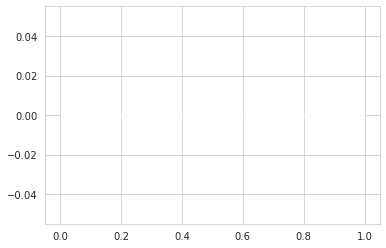

In [12]:
# Get the times that buses are in our corridors
z = []
dates = data['locationtime'].values
dates
for time in dates:
    x = int(datetime.fromtimestamp(time).strftime("%-M"))/60
    y = int(datetime.fromtimestamp(time).strftime("%H"))
    z.append(x+y)
plt.hist(z, bins=62)

In [13]:
# Get the average number of traversals per corridor
# Want count of unique trip ids for each segment id
traversal_data = data.groupby(['seg_compkey']).nunique('tripid').reset_index()
for corridor in corridor_segments:
    corridor_data = traversal_data.loc[traversal_data['seg_compkey'].isin(list(corridor_segments[corridor]))]
    print(corridor_data['lat'].mean())

nan
nan
nan
nan
nan
nan
nan
nan
nan


In [14]:
# Get the top ten vehicles with most tracked locations
vehicle_counts = data.groupby('vehicleid').count().reset_index()[['vehicleid', 'lat']]
vehicle_list = vehicle_counts.sort_values('lat', ascending=False)
vehicle_list = vehicle_list.iloc[:10,:]
vehicle_list = vehicle_list['vehicleid'].values
corridor_data_10 = data[data['vehicleid'].isin(vehicle_list)]
print(f"Number of tracks for best 10 routes: {len(corridor_data_10)}")

# Get the data corresponding to ten random vehicles
vehicle_list = vehicle_counts.sample(10)
vehicle_list = vehicle_list.sort_values('lat', ascending=False)
vehicle_list = vehicle_list.iloc[0:1,:]
vehicle_list = vehicle_list['vehicleid'].values
corridor_data_rand = data[data['vehicleid'].isin(vehicle_list)]
print(f"Number of tracks for best random route: {len(corridor_data_rand)}")

Number of tracks for best 10 routes: 0


ValueError: a must be greater than 0 unless no samples are taken

### Generate Densities by Random Sampling

In [ ]:
# 1000 iterations for random 10 vehicle ids from past two weeks
best_route_name = []
best_route_count = []
for i in range(0, 1000):
    sample = vehicle_counts.sample(10)
    sample = sample.sort_values('lat', ascending=False)
    sample = sample.iloc[0:1,:]
    best_route_name.append(sample['vehicleid'].values[0])
    best_route_count.append(sample['lat'].values[0])

# The top 20 vehicles
top_route_name = []
top_route_count = []
sample = vehicle_counts.sort_values('lat', ascending=False)
sample = sample.iloc[:10,:]
top_route_name.append(sample['vehicleid'].values)
top_route_count.append(sample['lat'].values)
top_route_count = list(top_route_count[0])

# All vehicles
all_route_count = list(vehicle_counts['lat'].values)

In [ ]:
# Distribution of number of tracks across network
fig = plt.figure(figsize=(10,6))
sns.kdeplot(best_route_count, bw_adjust=1)
sns.kdeplot(top_route_count, bw_adjust=1)
sns.kdeplot(all_route_count, bw_adjust=1)
fig.legend(labels=['Top Sampled Count','Top Un-Sampled Count','All Counts'])

### Generate Spatial Heatmaps

In [ ]:
pd.unique(corridor_data_rand['route_short_name'])

In [ ]:
# Initialize the map
f_map = folium.Map(
    location=[47.606209, -122.332069],
    zoom_start=11,
    prefer_canvas=True)

# Create and add layer for all the sampled coordinate data
# lats = sampled['lat'].tolist()
# lons = sampled['lon'].tolist()
# points = zip(lats, lons)
# points = list(points)
# HeatMap(
#     data=points,
#     name='Points',
#     radius=8,
#     min_opacity=0.2
# ).add_to(f_map)

# Create and add layer for all the sampled coordinate data in our corridors
lats = corridor_data_rand['lat'].tolist()
lons = corridor_data_rand['lon'].tolist()
points = zip(lats, lons)
points = list(points)
HeatMap(
    data=points,
    name='Points',
    radius=8,
    min_opacity=0.2
).add_to(f_map)

folium.LayerControl().add_to(f_map)

# Save map and plot in notebook
f_map.save(f"./local_sampled_map.html")
f_map